# Perceived Income Risks and Macroeconomic Conditions


- This notebook first downloads macroeconomic series 
- Then we examine the correlation of higher moments of labor income risks and these macro series 

In [1]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
from statsmodels.graphics import tsaplots as tsplt

In [2]:
## some configurations on plotting 
plt.style.use('ggplot')
plt.rcParams.update({'figure.max_open_warning': 0})
#from IPython.display import set_matplotlib_formats
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 15

#set_matplotlib_formats('pdf','png','jpg')
#plt.rcParams['savefig.dpi'] = 75
#plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
#plt.rcParams['axes.labelsize'] = 18
#plt.rcParams['axes.titlesize'] = 20
#plt.rcParams['lines.linewidth'] = 2.0
#plt.rcParams['lines.markersize'] = 8
#plt.rcParams['legend.fontsize'] = 14

#plt.rcParams['text.usetex'] = True

pd.options.display.float_format = '{:,.2f}'.format

###  1. Download macro series 

In [3]:
## time span 

start = datetime.datetime(2000, 1, 30)
end = datetime.datetime(2023, 3, 30)

In [4]:
## downloading the data from Fred

sp500D= web.DataReader('sp500', 'fred', start, end)
vixD = web.DataReader('VIXCLS','fred',start,end)
he = web.DataReader('CES0500000003','fred',start,end) #hourly earning private
ue = web.DataReader('UNRATE','fred',start,end)
cpi = web.DataReader('CPIAUCSL','fred',start,end)

## rename 

vixD = vixD.rename(columns={'VIXCLS':'vix'})
he = he.rename(columns={'CES0500000003':'he'})
ue = ue.rename(columns={'UNRATE':'ue'})
cpi = cpi.rename(columns={'CPIAUCSL':'cpi'})

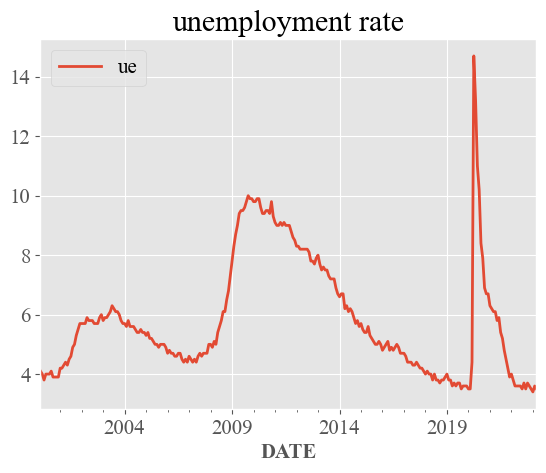

In [5]:
## ue rate 
ue.plot(lw = 2)
ueplt = plt.title('unemployment rate')

<AxesSubplot:xlabel='DATE'>

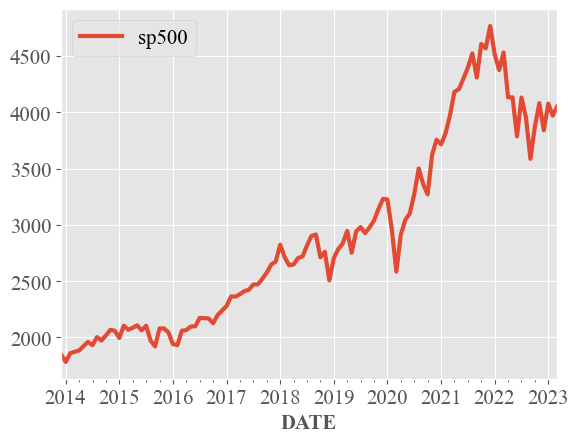

In [6]:
## collapse to monthly data
sp500D.index = pd.to_datetime(sp500D.index)
sp500M = sp500D.resample('M').last()

vixD.index = pd.to_datetime(vixD.index)
vixM = vixD.resample('M').mean()

sp500M.plot(lw = 3)
#sp500Mplt = plt.title('S&P 500 (end of month)')

In [7]:
## compute change/growths 

sp500MR = np.log(sp500M).diff(periods = 3)

## quarterly wage growth  
he = np.log(he).diff(periods = 3)
he.columns = ['he']
 

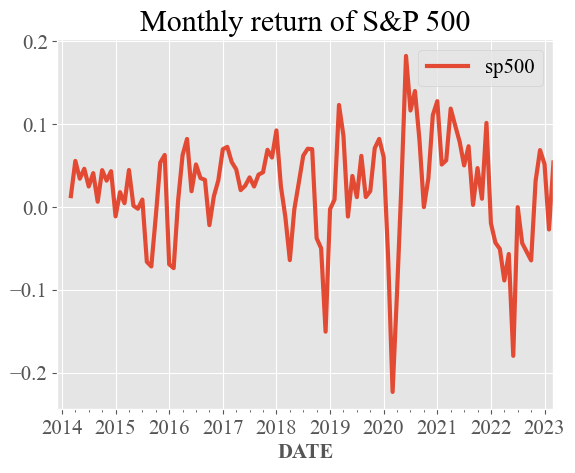

In [8]:
sp500MR.plot(lw = 3 )
sp500MRplt = plt.title('Monthly return of S&P 500')

<AxesSubplot:xlabel='DATE'>

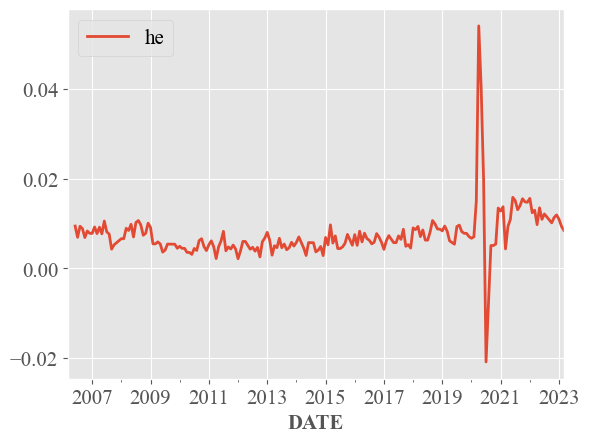

In [9]:
he.plot(lw = 2)

In [10]:
# adjusting the end-of-month dates to the begining-of-month for combining
sp500MR.index = sp500MR.index.shift(1,freq='D')
vixM.index = vixM.index.shift(1,freq='D')

In [11]:
## merge all monthly variables 

macroM = pd.concat([sp500MR,
                    vixM,
                    he,
                   ue,
                   cpi],
                   join="inner",
                   axis=1)

In [12]:
macroM

,sp500,vix,he,ue,cpi
DATE,,,,,
2014-01-01,NaN,14.19,0.01,6.60,235.29
2014-02-01,NaN,14.24,0.01,6.70,235.55
2014-03-01,NaN,15.47,0.01,6.70,236.03
2014-04-01,0.01,14.84,0.00,6.20,236.47
2014-05-01,0.06,14.20,0.00,6.30,236.92
...,...,...,...,...,...
2022-11-01,-0.06,30.01,0.01,3.60,298.60
2022-12-01,0.03,23.30,0.01,3.50,298.99
2023-01-01,0.07,21.78,0.01,3.40,300.54


In [13]:
## save macroM for further analysis 
macroM.to_stata('../OtherData/macroM_raw.dta')

## 1.2 job flow rates 

In [14]:
flow = pd.read_stata('../OtherData/CPS_worker_flows_SA.dta')

In [15]:
flow['date'] = flow['year'].astype(int).astype(str) + '-' + flow['month'].astype(int).astype(str)

# Convert 'date' column to datetime format
flow['date'] = pd.to_datetime(flow['date'], format='%Y-%m')

# Set the 'date' column as the index
flow.set_index('date', inplace=True)

In [16]:
## time aggregation 

flow['eurate_sa_1y'] = (1 -flow['eurate_sa']).rolling(window=12).apply(lambda x: 1-x.prod() )
flow['uerate_sa_3m'] = (1 -flow['uerate_sa']).rolling(window=3).apply(lambda x: 1-x.prod() )

## move forward to get realizations
flow['eurate_sa_1y_fr'] = flow['eurate_sa_1y'].shift(-12)
flow['uerate_sa_3m_fr'] = flow['uerate_sa_3m'].shift(-3)

In [17]:
macroM = pd.merge(macroM,
                 flow,
                 left_index=True,
                 right_index=True,
                 how='inner')

In [18]:
macroM

,sp500,vix,he,ue,cpi,year,eurate_sa,enrate_sa,uerate_sa,unrate_sa,...,j2jrate_sa,urate_sa,time_agg_adj,s,f,month,eurate_sa_1y,uerate_sa_3m,eurate_sa_1y_fr,uerate_sa_3m_fr
2014-01-01,NaN,14.19,0.01,6.60,235.29,2014,0.01,0.02,0.21,0.23,...,0.02,0.07,1.13,0.01,0.24,1.00,0.15,0.50,0.14,0.52
2014-02-01,NaN,14.24,0.01,6.70,235.55,2014,0.01,0.02,0.21,0.23,...,0.02,0.07,1.13,0.01,0.24,2.00,0.15,0.50,0.14,0.52
2014-03-01,NaN,15.47,0.01,6.70,236.03,2014,0.01,0.02,0.22,0.23,...,0.02,0.06,1.13,0.01,0.24,3.00,0.14,0.51,0.13,0.52
2014-04-01,0.01,14.84,0.00,6.20,236.47,2014,0.01,0.02,0.22,0.23,...,0.02,0.06,1.14,0.01,0.25,4.00,0.14,0.52,0.13,0.52
2014-05-01,0.06,14.20,0.00,6.30,236.92,2014,0.01,0.02,0.22,0.23,...,0.02,0.06,1.14,0.01,0.25,5.00,0.14,0.52,0.13,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.08,16.96,0.02,5.40,271.76,2021,0.01,0.03,0.24,0.22,...,0.02,0.06,1.15,0.01,0.28,7.00,0.14,0.55,NaN,0.59
2021-08-01,0.05,17.60,0.01,5.20,272.87,2021,0.01,0.02,0.25,0.23,...,0.02,0.05,1.15,0.01,0.28,8.00,0.13,0.57,NaN,0.62
2021-09-01,0.07,17.47,0.01,4.80,274.03,2021,0.01,0.03,0.25,0.22,...,0.02,0.05,1.16,0.01,0.29,9.00,0.13,0.57,NaN,NaN
2021-10-01,0.00,19.82,0.02,4.50,276.52,2021,0.01,0.03,0.28,0.24,...,0.02,0.04,1.18,0.01,0.33,10.00,0.12,0.59,NaN,NaN


### 1.3 median wage growth

In [19]:
## URLs from Atlanta Fed wage tracker
URL_wage_tracker = 'https://www.atlantafed.org/-/media/documents/datafiles/chcs/wage-growth-tracker/wage-growth-data.xlsx'

## save it to stata
wage_tracker = pd.read_excel(URL_wage_tracker,
                             sheet_name='data_overall',
                             skiprows= [0])

wage_tracker = wage_tracker.rename(columns={'Unnamed: 0':'date'})
wage_tracker.index = pd.to_datetime(wage_tracker['date'])
wage_tracker.index.name='date'
wage_tracker = wage_tracker.apply(pd.to_numeric, errors='coerce')

for var in wage_tracker.columns:
    wage_tracker = wage_tracker.rename(columns={var:'wage_gr_'+var})
    
    
macroM = pd.merge(macroM,
                  wage_tracker,
                  left_index=True,
                  right_index=True,
                  how='inner')

In [20]:
macroM.

,sp500,vix,he,ue,cpi,year,eurate_sa,enrate_sa,uerate_sa,unrate_sa,...,wage_gr_Male,wage_gr_Job Stayer,wage_gr_Job Switcher,wage_gr_Paid Hourly,wage_gr_Overall: Weighted,wage_gr_Overall: Weighted 97,wage_gr_Overall: Weekly Basis,wage_gr_Overall: 25/20 trimmed mean,wage_gr_Lower 1/2 of wage distn,wage_gr_Upper 1/2 of wage distn
2014-01-01,NaN,14.19,0.01,6.60,235.29,2014,0.01,0.02,0.21,0.23,...,2.60,2.00,2.90,2.10,2.40,2.60,2.60,2.50,2.40,2.20
2014-02-01,NaN,14.24,0.01,6.70,235.55,2014,0.01,0.02,0.21,0.23,...,2.70,2.10,3.10,2.40,2.50,2.60,2.90,2.60,2.70,2.20
2014-03-01,NaN,15.47,0.01,6.70,236.03,2014,0.01,0.02,0.22,0.23,...,2.70,2.10,3.00,2.30,2.50,2.60,3.00,2.60,2.70,2.20
2014-04-01,0.01,14.84,0.00,6.20,236.47,2014,0.01,0.02,0.22,0.23,...,2.60,2.20,2.60,2.20,2.30,2.50,3.00,2.50,2.40,2.20
2014-05-01,0.06,14.20,0.00,6.30,236.92,2014,0.01,0.02,0.22,0.23,...,2.40,2.20,2.50,2.10,2.40,2.60,2.90,2.50,2.20,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.08,16.96,0.02,5.40,271.76,2021,0.01,0.03,0.24,0.22,...,3.50,3.20,4.40,3.90,4.20,4.60,3.60,3.70,4.60,3.10
2021-08-01,0.05,17.60,0.01,5.20,272.87,2021,0.01,0.02,0.25,0.23,...,3.50,3.30,4.80,4.10,4.40,4.70,4.40,4.00,5.10,3.10
2021-09-01,0.07,17.47,0.01,4.80,274.03,2021,0.01,0.03,0.25,0.22,...,3.40,3.50,5.40,4.30,4.70,5.10,4.50,4.30,5.70,3.00
2021-10-01,0.00,19.82,0.02,4.50,276.52,2021,0.01,0.03,0.28,0.24,...,3.50,3.70,5.10,4.20,4.40,4.70,4.80,4.30,5.40,3.20


###  2. Loading and cleaning perceived income series

In [21]:
## loading the stata file
SCEProbIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')
SCEDstIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEDstIndM.dta')

In [22]:
# merge the two 

SCEIndM = pd.merge(SCEProbIndM,
                   SCEDstIndM,
                   on = ['userid','date'],
                  how='outer')

In [23]:
## subselect the dataframe
sub_var = ['date',
           'userid',
           'Q24_var',
           'Q24_mean',
           'Q24_iqr',
           'Q24_rmean',
           'Q24_rvar']
dem_var = ['Q32',  ## age
           'Q33',  ## gender
           'Q36',  ## education (1-8 low to high, 9 other)
           'byear', ## cohort
           'D6',
           'Q6new']

sub_var2 = ['IncSkew']

sub_var3 = ['Q13new', ## 1year separation
            'Q22new'] ## 3m job finding

IncSCEIndMoms = SCEIndM[sub_var+dem_var+sub_var2+sub_var3]

#IncSCEIndMomsEst = SCEDstIndM[sub_var2]

## drop nan observations
IncSCEIndMoms = IncSCEIndMoms.dropna(how='any')
#IncSCEIndMomsEst = IncSCEIndMomsEst.dropna(how='any')

In [24]:
## rename

IncSCEIndMoms = IncSCEIndMoms.rename(columns={'Q24_mean': 'incexp',
                                               'Q24_var': 'incvar',
                                               'Q24_iqr': 'inciqr',
                                               'Q24_rmean':'rincexp',
                                               'Q24_rvar': 'rincvar',
                                              'IncSkew':'incskew',
                                              'Q13new':'exp_s',
                                              'Q22new':'exp_f',
                                              'D6':'HHinc',
                                              'Q32':'age',
                                              'Q33':'gender',
                                              'Q36':'educ',
                                              'Q6new': 'Stkprob'
                                             })

In [25]:
## deal with clusterring skewness value around zero first

#IncSCEIndMoms['incskew'] = IncSCEIndMoms['incskew'].copy().replace(0,np.nan)

In [26]:
## create new groups

IncSCEIndMoms['educ_gr'] = pd.cut(IncSCEIndMoms['educ'],
                                   2,
                                   labels= ['low','high'])


IncSCEIndMoms['HHinc_gr'] = pd.cut(IncSCEIndMoms['HHinc'],
                                   2,
                                   labels= ['low','high'])

IncSCEIndMoms['age_gr'] = pd.cut(IncSCEIndMoms['age'],
                                 3,
                                 labels= ['young','middle-age','old'])


IncSCEIndMoms['byear_gr'] = pd.cut(IncSCEIndMoms['byear'],
                                   4,
                                   labels = ['50s','60s','70s','80s'])


## categorical variables

vars_cat = ['HHinc','gender','age_gr','byear_gr','HHinc_gr','educ_gr']

for var in vars_cat:
    IncSCEIndMoms[var] = pd.Categorical(IncSCEIndMoms[var],ordered = False)

In [27]:
moms = ['incexp','incvar','inciqr','rincexp','rincvar','incskew','exp_s','exp_f']
#moms_est = ['IncSkew','IncKurt']

## compute population summary stats for these ind moms
IncSCEPopMomsMed = pd.pivot_table(data = IncSCEIndMoms,
                                  index=['date'],
                                  values = moms,
                                  aggfunc= 'median').reset_index().rename(columns={'incexp': 'expMed',
                                                                                   'rincexp':'rexpMed',
                                                                                   'incvar': 'varMed',
                                                                                   'inciqr': 'iqrMed',
                                                                                   'rincvar':'rvarMed',
                                                                                  'incskew':'skewMed',
                                                                                     'exp_s':'exp_sMed',
                                                                                    'exp_f':'exp_fMed'})

IncSCEPopMomsMean = pd.pivot_table(data = IncSCEIndMoms,
                                   index = ['date'],
                                   values = moms,
                                   aggfunc = 'mean').reset_index().rename(columns={'incexp': 'expMean',
                                                                                   'rincexp':'rexpMean',
                                                                                   'incvar': 'varMean',
                                                                                   'inciqr': 'iqrMean',
                                                                                   'rincvar':'rvarMean',
                                                                                  'incskew':'skewMean', 
                                                                                   'exp_s':'exp_sMean',
                                                                                    'exp_f':'exp_fMean'})



IncSCEPopMomsStd = pd.pivot_table(data = IncSCEIndMoms,
                                   index = ['date'],
                                   values = moms,
                                   aggfunc = 'std').reset_index().rename(columns={'incexp': 'expStd',
                                                                                   'rincexp':'rexpStd',
                                                                                   'incvar': 'varStd',
                                                                                   'inciqr': 'iqrStd',
                                                                                   'rincvar':'rvarStd',
                                                                                  'incskew':'skewStd',
                                                                                  'exp_s':'exp_sStd',
                                                                                    'exp_f':'exp_fStd'})

In [28]:
T = len(IncSCEPopMomsMed)

### 3. Combinine the macro series and SCE data 

In [29]:
## streamline the dates for merging

# adjusting the end-of-month dates to the begining-of-month for combining

IncSCEPopMomsMed.index = pd.DatetimeIndex(IncSCEPopMomsMed['date'] ,freq='infer')
IncSCEPopMomsMean.index = pd.DatetimeIndex(IncSCEPopMomsMean['date'] ,freq='infer')
IncSCEPopMomsStd.index = pd.DatetimeIndex(IncSCEPopMomsStd['date'] ,freq='infer')

In [30]:
dt_combM = pd.concat([macroM,
                      IncSCEPopMomsMed,
                      IncSCEPopMomsMean,
                     IncSCEPopMomsStd],
                     join="inner",
                     axis=1).drop(columns=['date'])

In [31]:
dt_combM.tail()

,sp500,vix,he,ue,cpi,year,eurate_sa,enrate_sa,uerate_sa,unrate_sa,...,rexpMean,rvarMean,exp_fStd,exp_sStd,expStd,iqrStd,skewStd,varStd,rexpStd,rvarStd
2019-12-01,0.07,12.52,0.01,3.60,258.62,2019,0.01,0.03,0.28,0.24,...,0.00,0.00,32.03,19.32,0.02,0.01,0.36,0.00,0.03,0.00
2020-01-01,0.08,13.76,0.01,3.50,259.04,2020,0.01,0.02,0.27,0.25,...,-0.00,0.00,29.25,17.36,0.02,0.02,0.49,0.00,0.03,0.00
2020-02-01,0.06,13.94,0.01,3.50,259.25,2020,0.02,0.03,0.25,0.24,...,-0.00,0.00,30.00,16.72,0.02,0.02,0.45,0.00,0.03,0.00
2020-03-01,-0.06,19.63,0.02,4.40,258.12,2020,0.11,0.06,0.20,0.33,...,-0.00,0.00,29.40,20.18,0.02,0.02,0.36,0.00,0.03,0.00
2020-04-01,-0.22,57.74,0.05,14.70,256.09,2020,0.04,0.03,0.31,0.15,...,-0.01,0.00,29.78,20.91,0.02,0.02,0.33,0.00,0.03,0.00


<AxesSubplot:title={'center':'Cross-sectionl std of expected Growth'}>

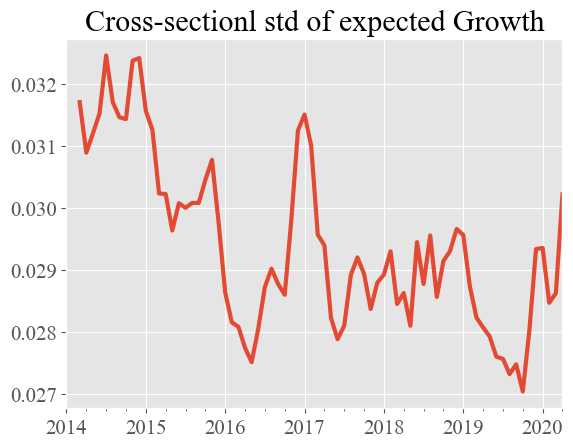

In [32]:
dt_combM['rexpStd'].rolling(3).mean().plot(title='Cross-sectionl std of expected Growth')

In [33]:
## export to stata
dt_combM.to_stata('../SurveyData/SCE/IncExpSCEPopMacroM.dta')

C:\Program Files\Anaconda3\lib\site-packages\pandas\io\stata.py:2491: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    wage_gr_Full-time   ->   wage_gr_Full_time
    wage_gr_College degree   ->   wage_gr_College_degree
    wage_gr_Age 25-54   ->   wage_gr_Age_25_54
    wage_gr_Job Stayer   ->   wage_gr_Job_Stayer
    wage_gr_Job Switcher   ->   wage_gr_Job_Switcher
    wage_gr_Paid Hourly   ->   wage_gr_Paid_Hourly
    wage_gr_Overall: Weighted   ->   wage_gr_Overall__Weighted
    wage_gr_Overall: Weighted 97   ->   wage_gr_Overall__Weighted_97
    wage_gr_Overall: Weekly Basis   ->   wage_gr_Overall__Weekly_Basis
    wage_gr_Overall: 25/20 trimmed mean   ->   wage_gr_Overall__25_20_trimmed_m
    wage_gr_Lower 1/2 of wage distn   ->   wage_gr_Lower_1_2_of_wage_distn
    wage_gr_Upper 1/2 of wage distn   ->   wage_gr_Upper_1_2_of_wage_distn

If this is not what you expect, please make sure you have Stata-com

In [34]:
## date index for panel

IncSCEIndMoms.index = IncSCEIndMoms['date']
IncSCEIndMoms.index.name = None

In [35]:
## merge individual moments and macro series

dt_combIndM = pd.merge(macroM,
                       IncSCEIndMoms,
                       left_index = True,
                       right_on ='date')

In [36]:
dt_combIndM['']

,sp500,vix,he,ue,cpi,year,eurate_sa,enrate_sa,uerate_sa,unrate_sa,...,byear,HHinc,Stkprob,incskew,exp_s,exp_f,educ_gr,HHinc_gr,age_gr,byear_gr
2014-01-01,NaN,14.19,0.01,6.60,235.29,2014,0.01,0.02,0.21,0.23,...,"1,983.00",10.00,50.00,0.22,15.00,60.00,high,high,young,70s
2014-01-01,NaN,14.19,0.01,6.60,235.29,2014,0.01,0.02,0.21,0.23,...,"1,967.00",9.00,50.00,0.00,10.00,20.00,low,high,middle-age,60s
2014-01-01,NaN,14.19,0.01,6.60,235.29,2014,0.01,0.02,0.21,0.23,...,"1,960.00",6.00,70.00,-0.57,50.00,33.00,low,low,old,60s
2014-01-01,NaN,14.19,0.01,6.60,235.29,2014,0.01,0.02,0.21,0.23,...,"1,972.00",8.00,30.00,0.00,10.00,75.00,high,high,middle-age,70s
2014-01-01,NaN,14.19,0.01,6.60,235.29,2014,0.01,0.02,0.21,0.23,...,"1,981.00",4.00,40.00,1.94,60.00,30.00,low,low,young,70s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,-0.22,57.74,0.05,14.70,256.09,2020,0.04,0.03,0.31,0.15,...,"1,992.00",8.00,50.00,0.00,15.00,30.00,high,high,young,80s
2020-04-01,-0.22,57.74,0.05,14.70,256.09,2020,0.04,0.03,0.31,0.15,...,"1,982.00",5.00,12.00,0.00,1.00,75.00,high,low,middle-age,70s
2020-04-01,-0.22,57.74,0.05,14.70,256.09,2020,0.04,0.03,0.31,0.15,...,"1,962.00",7.00,85.00,0.00,0.00,40.00,low,high,old,60s
2020-04-01,-0.22,57.74,0.05,14.70,256.09,2020,0.04,0.03,0.31,0.15,...,"1,973.00",11.00,80.00,0.54,1.00,21.00,high,high,middle-age,70s


In [37]:
## export to stata
dt_combIndM.to_stata('../SurveyData/SCE/IncExpSCEIndMacroM.dta')

C:\Program Files\Anaconda3\lib\site-packages\pandas\io\stata.py:2491: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    wage_gr_Full-time   ->   wage_gr_Full_time
    wage_gr_College degree   ->   wage_gr_College_degree
    wage_gr_Age 25-54   ->   wage_gr_Age_25_54
    wage_gr_Job Stayer   ->   wage_gr_Job_Stayer
    wage_gr_Job Switcher   ->   wage_gr_Job_Switcher
    wage_gr_Paid Hourly   ->   wage_gr_Paid_Hourly
    wage_gr_Overall: Weighted   ->   wage_gr_Overall__Weighted
    wage_gr_Overall: Weighted 97   ->   wage_gr_Overall__Weighted_97
    wage_gr_Overall: Weekly Basis   ->   wage_gr_Overall__Weekly_Basis
    wage_gr_Overall: 25/20 trimmed mean   ->   wage_gr_Overall__25_20_trimmed_m
    wage_gr_Lower 1/2 of wage distn   ->   wage_gr_Lower_1_2_of_wage_distn
    wage_gr_Upper 1/2 of wage distn   ->   wage_gr_Upper_1_2_of_wage_distn

If this is not what you expect, please make sure you have Stata-com

### 4. Correlation with labor market outcomes 

In [38]:
corr_table = dt_combM.corr()
corr_table.to_excel('../Tables/corrM.xlsx')
corr_table

,sp500,vix,he,ue,cpi,year,eurate_sa,enrate_sa,uerate_sa,unrate_sa,...,rexpMean,rvarMean,exp_fStd,exp_sStd,expStd,iqrStd,skewStd,varStd,rexpStd,rvarStd
sp500,1.00,-0.77,-0.54,-0.47,-0.01,-0.07,-0.30,-0.22,-0.06,0.20,...,0.11,-0.35,-0.07,0.10,-0.05,0.03,0.04,-0.01,-0.20,-0.19
vix,-0.77,1.00,0.82,0.64,0.14,0.21,0.28,0.15,0.19,-0.44,...,-0.11,0.43,-0.07,0.02,-0.05,-0.05,-0.13,-0.01,0.11,0.34
he,-0.54,0.82,1.00,0.65,0.34,0.39,0.37,0.24,0.38,-0.47,...,-0.08,0.34,-0.32,0.12,-0.09,-0.15,-0.22,-0.13,0.06,0.27
ue,-0.47,0.64,0.65,1.00,-0.40,-0.39,0.22,-0.11,-0.28,-0.65,...,-0.43,0.62,0.23,0.30,0.37,0.15,0.03,0.03,0.50,0.42
cpi,-0.01,0.14,0.34,-0.40,1.00,0.96,0.16,0.37,0.75,0.18,...,0.25,-0.31,-0.65,-0.24,-0.53,-0.33,-0.30,-0.18,-0.42,-0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iqrStd,0.03,-0.05,-0.15,0.15,-0.33,-0.34,0.06,-0.04,-0.39,0.03,...,-0.15,0.59,0.10,0.10,0.31,1.00,0.15,0.92,0.27,0.59
skewStd,0.04,-0.13,-0.22,0.03,-0.30,-0.33,-0.13,-0.18,-0.32,0.01,...,-0.10,0.05,0.06,-0.01,0.08,0.15,1.00,0.12,-0.03,-0.03
varStd,-0.01,-0.01,-0.13,0.03,-0.18,-0.18,0.08,0.05,-0.28,0.10,...,-0.11,0.52,0.04,0.01,0.16,0.92,0.12,1.00,0.18,0.59
rexpStd,-0.20,0.11,0.06,0.50,-0.42,-0.52,0.19,-0.01,-0.46,-0.14,...,-0.57,0.45,0.42,0.35,0.60,0.27,-0.03,0.18,1.00,0.23


In [39]:
lag_loop = 7

def pval_str(pval):
    if pval < 0.01:
        star = '***'
    elif pval >= 0.01 and pval<0.05:
        star = '**'
    elif pval >= 0.05 and pval <= 0.1:
        star = '*'
    else:
        star = ''
    return star

def corrtostr(corr):
    return str(round(corr[0],2)) + str(pval_str(corr[1]))

def corrprint(corr,
              var):
    print('correlation coefficient betwen ue and median'+
              str(var) +
              ' is ' +
              str(round(corr[0],2)) +
              ', and p-value is ' +
              str(round(corr[1],2))
             )

corr_list = []
col_list = []


## mean
for moms in ['var','iqr','rvar','skew']:
    col_list.append('mean:'+str(moms))
    for lag in range(lag_loop):
        corr = st.pearsonr(np.array(dt_combM['he'][:-(lag+1)]),
                           np.array(dt_combM[str(moms)+'Mean'])[(lag+1):]
                          )
        corr_str = corrtostr(corr)
        corr_list.append(corr_str)
        #corrprint(corr,moms)

## median
for moms in ['var','iqr','rvar']:
    col_list.append('median:'+str(moms))
    for lag in range(lag_loop):
        corr = st.pearsonr(np.array(dt_combM['he'][:-(lag+1)]),
                           np.array(dt_combM[str(moms)+'Med'])[(lag+1):]
                          )
        corr_str = corrtostr(corr)
        corr_list.append(corr_str)
        #corrprint(corr, moms)



corr_array = np.array(corr_list).reshape([int(len(corr_list)/lag_loop),
                                          lag_loop])
corr_df = pd.DataFrame(corr_array,
                       index = col_list)

corr_df.T

,mean:var,mean:iqr,mean:rvar,mean:skew,median:var,median:iqr,median:rvar
0,-0.23**,-0.3***,-0.05,-0.07,-0.2*,-0.17,-0.15
1,-0.28**,-0.35***,-0.21*,0.31***,-0.04,0.09,-0.25**
2,-0.18,-0.22*,-0.2*,0.06,0.02,0.06,-0.27**
3,-0.23*,-0.25**,-0.2*,-0.03,0.1,0.08,-0.2*
4,-0.1,-0.2*,-0.1,-0.2*,-0.13,-0.11,-0.33***
5,-0.21*,-0.33***,-0.22*,-0.12,-0.11,-0.17,-0.36***
6,-0.34***,-0.44***,-0.23*,-0.02,-0.3**,-0.16,-0.28**


In [40]:
## output tables to latex

beginningtex = """
\\begin{table}[ht]
\\centering
\\begin{adjustbox}{width={\\textwidth}}
\\begin{threeparttable}
\\caption{Current Labor Market Conditions and Perceived Income Risks}
\\label{macro_corr_he}
"""

endtex = """\\begin{tablenotes}
\item *** p$<$0.001, ** p$<$0.01 and * p$<$0.05.
\item This table reports correlation coefficients between different perceived income moments(inc for nominal
and rinc for real) at time
$t$ and the quarterly growth rate in hourly earning at $t,t-1,...,t-k$.
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""

## write to latex

f = open('../Tables/latex/macro_corr_he.tex', 'w')
f.write(beginningtex)
tb_ltx = corr_df.T.to_latex().replace('llllll','cccccc')
f.write(tb_ltx)
f.write(endtex)
f.close()

## output table to excel
corr_df.T.to_excel('../Tables/macro_corr_he.xlsx')

C:\Users\want\AppData\Local\Temp\ipykernel_10744\1472986633.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tb_ltx = corr_df.T.to_latex().replace('llllll','cccccc')


In [41]:
mom_dict = {'exp':'expected nominal growth',
          'rexp':'expected real growth',
          'var':'nominal income risk',
          'rvar':'real income risk',
          'iqr':'nomial 75/25 IQR',
           'skew':'skewness'}

In [42]:
## moving average

dt_combM3mv = dt_combM.rolling(3).mean()

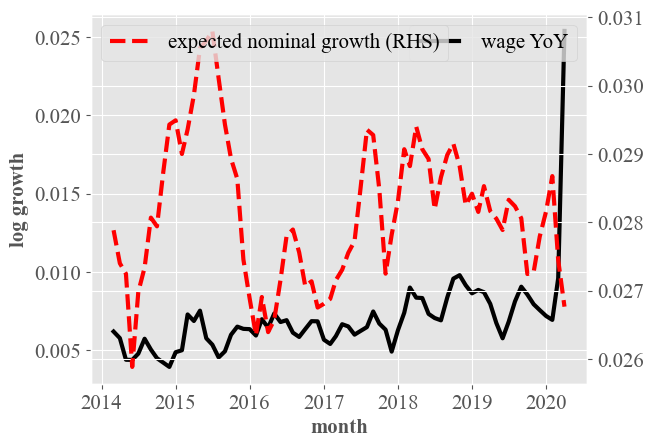

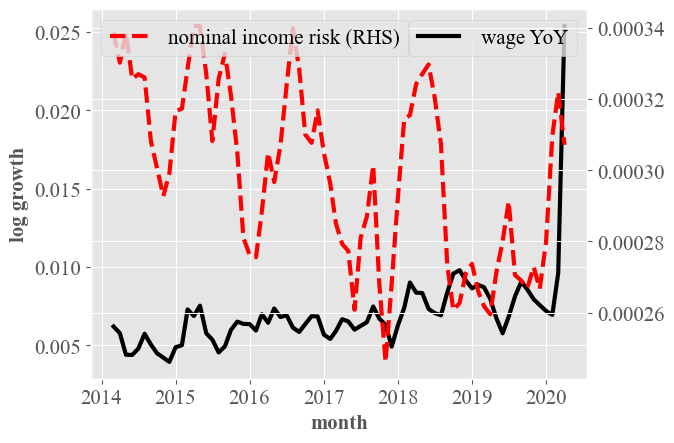

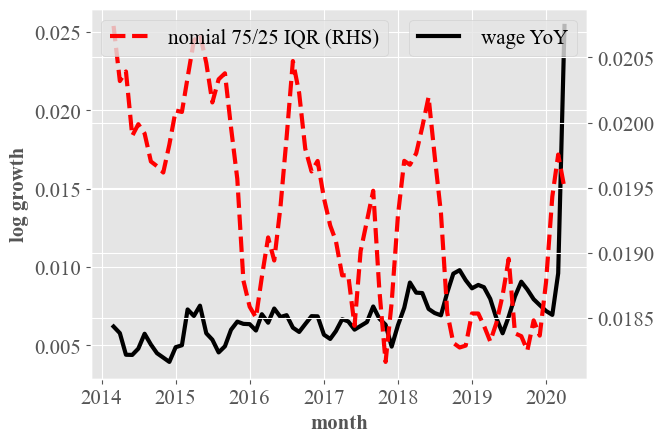

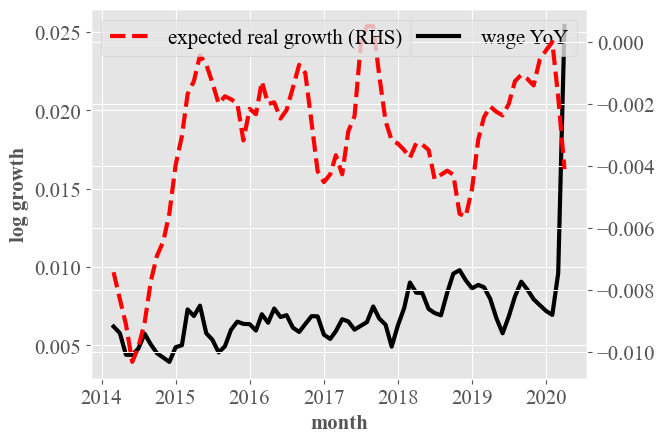

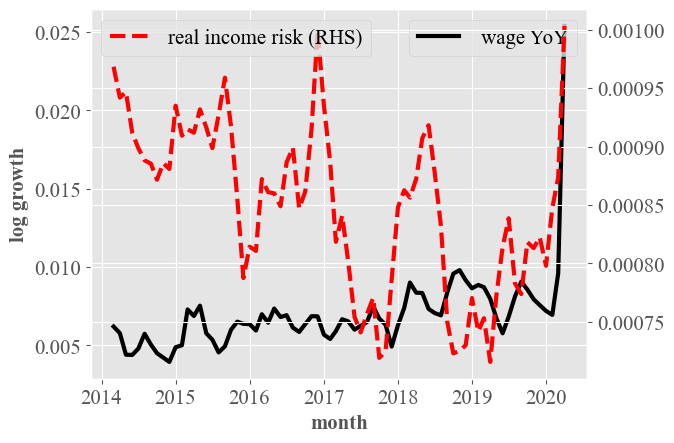

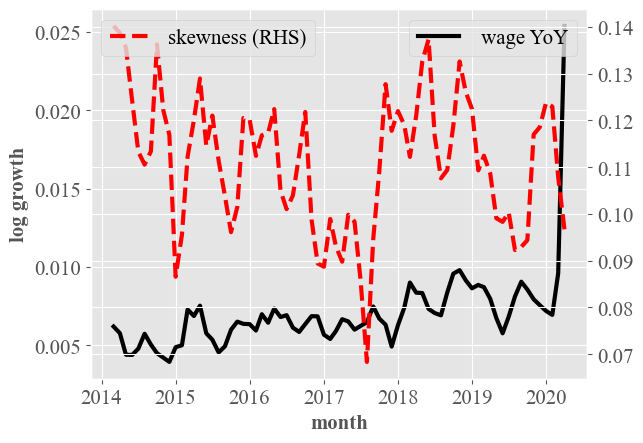

In [43]:
## plots of correlation for 3-month moving mean average

for i,moms in enumerate( ['exp','var','iqr','rexp','rvar','skew']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(dt_combM3mv['he'],
           color='black',
           label=' wage YoY')
    ax2.plot(dt_combM3mv[str(moms)+'Mean'],
             'r--',
             label=str(mom_dict[moms])+' (RHS)')
    ax.legend(loc= 1)
    ax.set_xlabel("month")
    ax.set_ylabel('log growth')
    ax2.legend(loc = 2)
    ax.tick_params(axis='both', 
                   which='major')
    ax2.tick_params(axis='both',
                    which='major')
    plt.savefig('../Graphs/pop/tsMean3mv'+str(moms)+'_he.jpg')

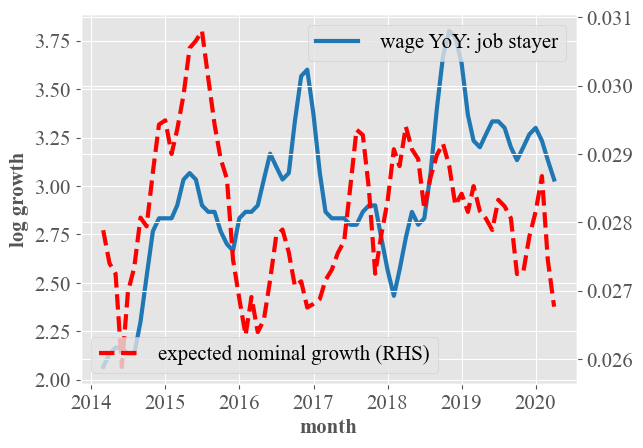

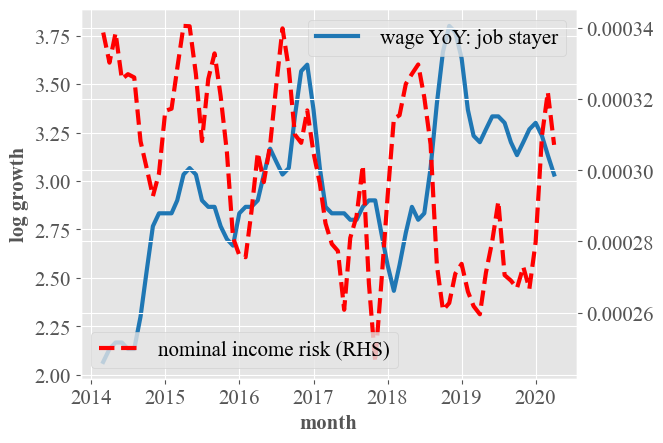

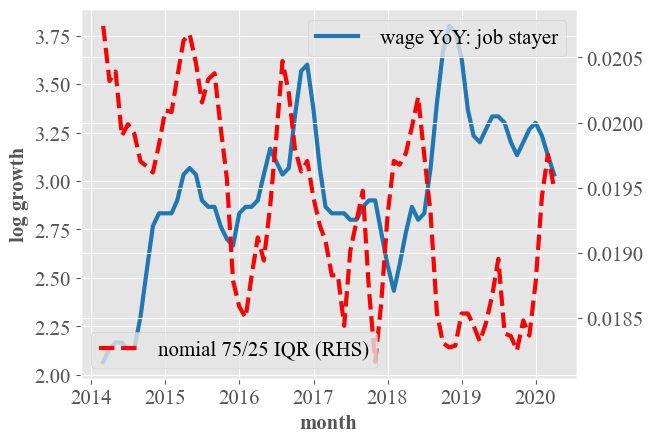

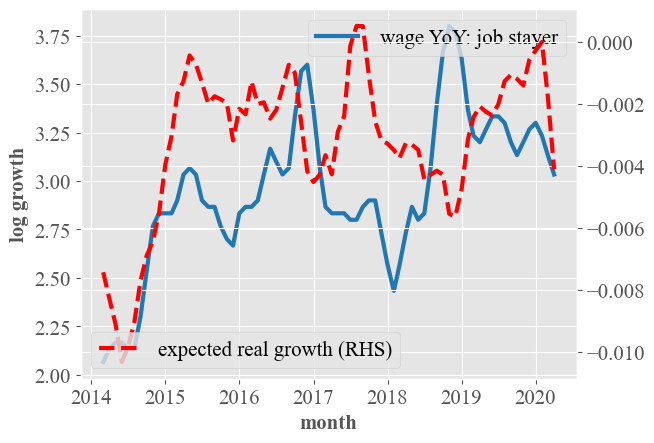

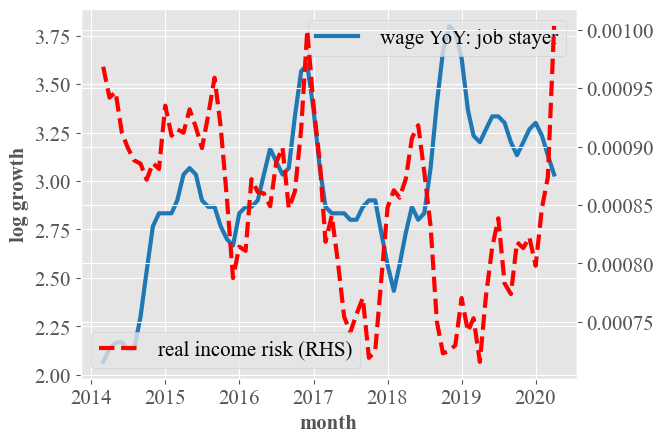

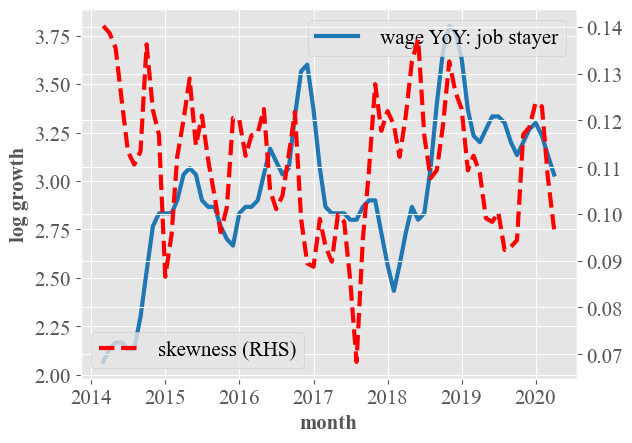

In [48]:
## plots of correlation for 3-month moving mean average

for i,moms in enumerate( ['exp','var','iqr','rexp','rvar','skew']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(dt_combM3mv['wage_gr_Job Stayer'],
           color='tab:blue',
           label=' wage YoY: job stayer')
    ax2.plot(dt_combM3mv[str(moms)+'Mean'],
             'r--',
             label=str(mom_dict[moms])+' (RHS)')
    ax.legend(loc= 1)
    ax.set_xlabel("month")
    ax.set_ylabel('log growth')
    ax2.legend(loc = 3)
    ax.tick_params(axis='both', 
                   which='major')
    ax2.tick_params(axis='both',
                    which='major')
    #plt.savefig('../Graphs/pop/tsMean3mv'+str(moms)+'_wage_growth_job_stayer.jpg')

## 5. Comparing job transition rates

In [44]:
dt_combM.tail()

,sp500,vix,he,ue,cpi,year,eurate_sa,enrate_sa,uerate_sa,unrate_sa,...,rexpMean,rvarMean,exp_fStd,exp_sStd,expStd,iqrStd,skewStd,varStd,rexpStd,rvarStd
2019-12-01,0.07,12.52,0.01,3.60,258.62,2019,0.01,0.03,0.28,0.24,...,0.00,0.00,32.03,19.32,0.02,0.01,0.36,0.00,0.03,0.00
2020-01-01,0.08,13.76,0.01,3.50,259.04,2020,0.01,0.02,0.27,0.25,...,-0.00,0.00,29.25,17.36,0.02,0.02,0.49,0.00,0.03,0.00
2020-02-01,0.06,13.94,0.01,3.50,259.25,2020,0.02,0.03,0.25,0.24,...,-0.00,0.00,30.00,16.72,0.02,0.02,0.45,0.00,0.03,0.00
2020-03-01,-0.06,19.63,0.02,4.40,258.12,2020,0.11,0.06,0.20,0.33,...,-0.00,0.00,29.40,20.18,0.02,0.02,0.36,0.00,0.03,0.00
2020-04-01,-0.22,57.74,0.05,14.70,256.09,2020,0.04,0.03,0.31,0.15,...,-0.01,0.00,29.78,20.91,0.02,0.02,0.33,0.00,0.03,0.00


Text(2014-01-01 00:00:00, 0.3, 'Correlation coef=-0.168')

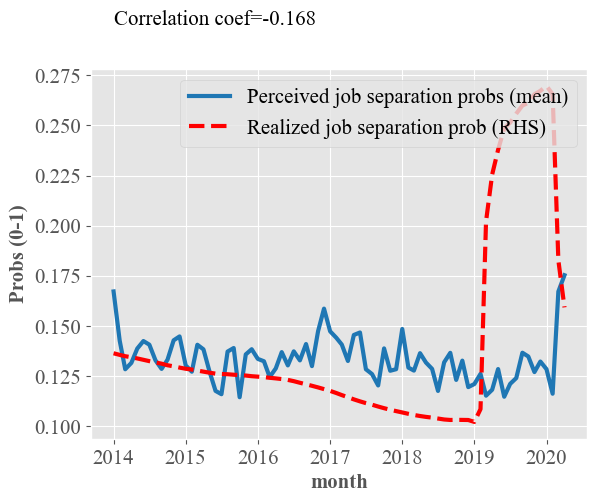

In [45]:
## plots of correlation for 3-month moving mean average

fig, ax = plt.subplots()

#ax.plot(dt_combM['exp_s'+'Med']/100,
#       color='black',
#       lw = lw,
#       label='Perceived job separation probs (median)')
ax.plot(dt_combM['exp_s'+'Mean']/100,
       color='tab:blue',
       label='Perceived job separation probs (mean)')

ax.plot(dt_combM['eurate_sa_1y_fr'],
         'r--',
         label='Realized job separation prob (RHS)')

ax.legend(loc= 1)
ax.set_xlabel("month")
ax.set_ylabel('Probs (0-1)')


ax.tick_params(axis='both', 
               which='major'
              )

corr = round(dt_combM[['exp_sMean','eurate_sa_1y_fr']].corr().iloc[0,1],3)

ax.text(dt_combM.index[0], 0.3, "Correlation coef="+str(corr))

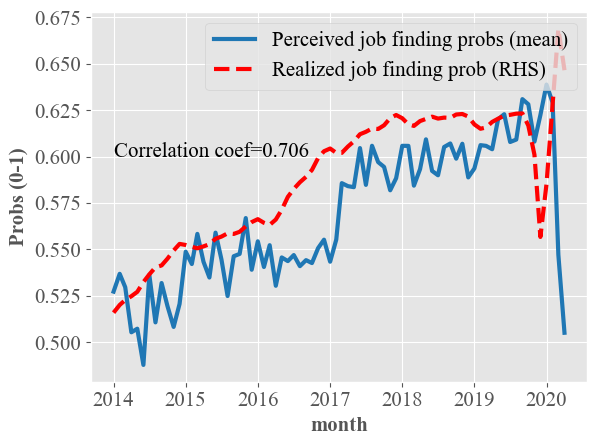

In [46]:
## plots of correlation for 3-month moving mean average

fig, ax = plt.subplots()
#ax.plot(dt_combM['exp_f'+'Med']/100,
#       color='black',
#       lw = lw,
#       label='Perceived job finding probs (median)')
ax.plot(dt_combM['exp_f'+'Mean']/100,
       color='tab:blue',
       label='Perceived job finding probs (mean)')

ax.plot(dt_combM['uerate_sa_3m_fr'],
         'r--',
         label='Realized job finding prob (RHS)')

corr = round(dt_combM[['exp_fMean','uerate_sa_3m_fr']].corr().iloc[0,1],3)

ax.text(dt_combM.index[0], 0.6, "Correlation coef="+str(corr))

ax.legend(loc= 1)
ax.set_xlabel("month")
ax.set_ylabel('Probs (0-1)')

ax.tick_params(axis='both', 
               which='major'
              )